# Notebook for the Chemostat Model

In [1]:
import numpy as np
from importlib import reload
import numpy.ma as ma
import scipy.optimize
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
import seaborn as sns
import Functions_for_Chemostat as ffc
from functools import partial
from scipy.integrate import odeint
from scipy.optimize import fsolve
from matplotlib import ticker, cm
from tqdm import tqdm  # Import tqdm for progress tracking
%matplotlib inline

sns.set()

## Growth functions depending on CTX concentration and parameters

R = Resistant = Triple = TEM-52

S = Susceptible = G238S = TEM-19

In [2]:
p_R = {"Vmax": 3.20e-4, "ka":69, "B": -96.5, "T":0.146, 
       "ec50": 27716, "h": 3.38, "k": 1.8e-4, "yxg": 2e9}
p_S = {"Vmax":6.69e-4, "ka":319, "B": -1.57, "T": 0.183, "ec50": 1.87, 
       "h": 3.42, "k": 1.8e-4, "yxg": 2e9}

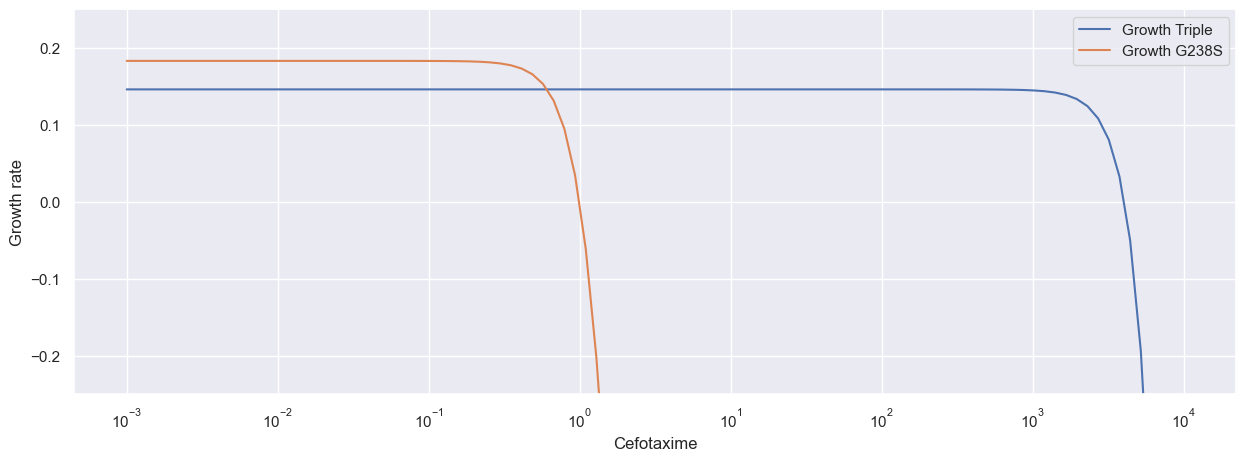

In [3]:
xval = np.logspace(-3, 4, num=100)
yvalx = [ffc.growth(a, **p_R) for a in xval]
yvaly = [ffc.growth(a, **p_S) for a in xval]
fig, axes = plt.subplots(figsize=(15,5))
axes.plot(xval, yvalx)
axes.plot(xval, yvaly)
axes.set_xlabel('Cefotaxime')
axes.set_ylabel('Growth rate')
axes.set_ylim(-0.25, 0.25)
axes.set_xscale('log')
axes.legend(tuple(['Growth Triple','Growth G238S']))


### Defining the antibiotic concentration and growth rate at equilibrium

In [4]:
func_equal_growth = lambda a: (ffc.growth(a, **p_R) - ffc.growth(a, **p_S))**2
sol_a_eq = fsolve(func_equal_growth, 0.6)[0] #0.6 is the initial value
mu_coex = ffc.growth(sol_a_eq, **p_R)

## Simulation of the chemostat

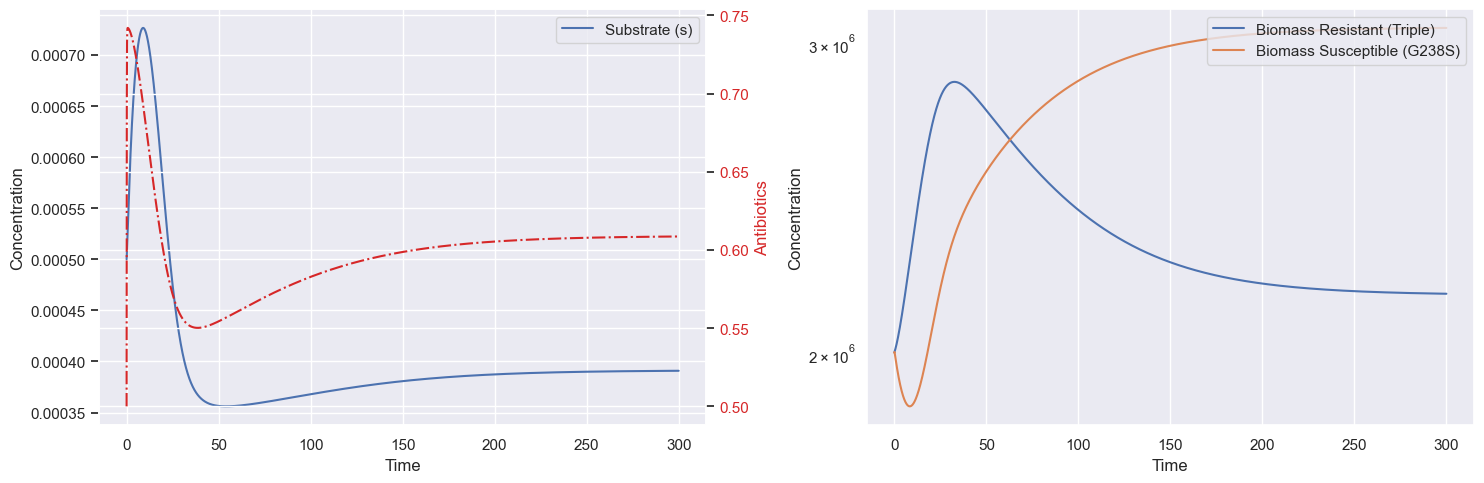

In [5]:
t = np.linspace(0,300,10000)
init = np.array([.0005, .5, 2*10**6, 2*10**6])
p_chemostat = {"d": 0.1, "feed_g": 0.003, "feed_a": 100, "degradation_a": 0}

result = odeint(ffc.chemostat_model, init, t, args=([p_R, p_S, p_chemostat],))

fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].plot(t, result[:,0])
color = 'tab:red'
axes2 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
axes2.set_ylabel('Antibiotics', color=color)  # we already handled the x-label with ax1
axes2.tick_params(axis='y', labelcolor=color)
axes2.plot(t, result[:,1], '-.', color=color)
    
axes[1].plot(t, result[:,2])
axes[1].plot(t, result[:,3])
    
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[0].set_ylabel('Concentration')
axes[1].set_ylabel('Concentration')
axes[1].set_yscale('log')
#axes[1].set_ylim([1e-3, 1e12])
axes[0].legend(tuple(['Substrate (s)', 'Antibiotics (a)']), loc="upper right")
axes[1].legend(tuple(['Biomass Resistant (Triple)', 'Biomass Susceptible (G238S)']), loc="upper right")
plt.tight_layout()

## Regular addition of antibiotics

Example simulation of a chemostat with regular addition of antibiotics

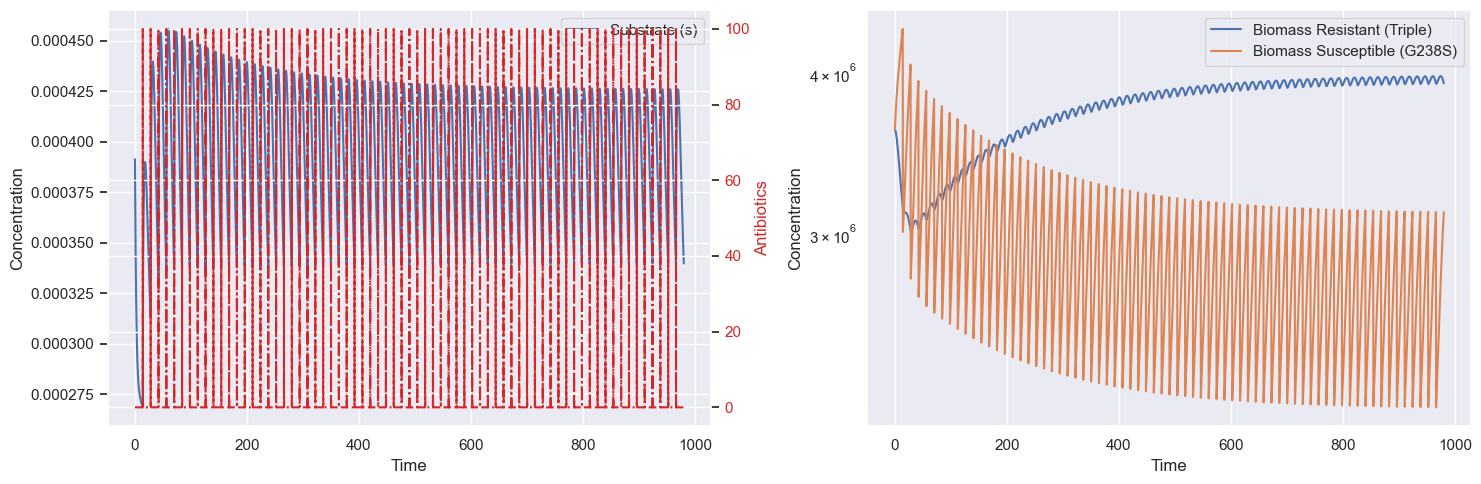

In [6]:
iterations = 70
interval = 14
amount = 100
g_feed_test = 0.004
a_feed_test = 0
d_graph = 0.1

approx_ss_popsize = ffc.N_tot(g_feed_test, d_graph, ffc.g_min(d_graph, ffc.growth(sol_a_eq, **p_R), **p_R), mu_coex = ffc.growth(sol_a_eq, **p_R), **p_R)
approx_gly = ffc.g_min(d_graph, ffc.growth(0, **p_R), **p_R)

t = np.linspace(0,interval*iterations,100*iterations*interval)
init = np.array([approx_gly, 0, 0.5*approx_ss_popsize, 0.5*approx_ss_popsize])
p_chemostat_intermittend = {"d": d_graph, "feed_g": g_feed_test, "feed_a": a_feed_test, "degradation_a": 0}

result = ffc.serial_chemostat(ffc.chemostat_model, init, iterations, interval, amount, parms=([p_R, p_S, p_chemostat_intermittend],))

fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].plot(t, result[:,0])
color = 'tab:red'
axes2 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
axes2.set_ylabel('Antibiotics', color=color)  # we already handled the x-label with ax1
axes2.tick_params(axis='y', labelcolor=color)
axes2.plot(t, result[:,1], '-.', color=color)
    
axes[1].plot(t, result[:,2])
axes[1].plot(t, result[:,3])
    
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[0].set_ylabel('Concentration')
axes[1].set_ylabel('Concentration')
axes[1].set_yscale('log')
#axes[1].set_ylim([1e-3, 1e12])
axes[0].legend(tuple(['Substrate (s)', 'Antibiotics (a)']), loc="upper right")
axes[1].legend(tuple(['Biomass Resistant (Triple)', 'Biomass Susceptible (G238S)']), loc="upper right")
plt.tight_layout()

In [7]:
ffc.equilibrium_ratio_serial(g_feed_test, interval, amount, d_graph, 0, p_R, p_S, sensitivity=0.001, max_iterations=50)

0.5433701171875001

In [8]:
ffc.calc_ratio(result[-1])

0.557367678278159

## Equilibrium fraction of the resistant strain for a range of substrate and antibiotic concentrations

A partial function with 100 ug/ml CTX added at the interval and for a dilution rate of 0.1/h.

In [9]:
eq_ratio_partial = partial(ffc.equilibrium_ratio_serial, amount=100, d=0.1, d_e_a=0, p_R=p_R, p_S=p_S, sensitivity=0.001, max_iterations=50)
equilibrium_ratio_array_intermittend = np.frompyfunc(eq_ratio_partial, 2, 1)

If saved data is used the line between 'tic' and 'toc' should be commented as wel as the export line.
Otherwise the load data should be commented

In [10]:
interval_array = np.linspace(5,50,100, endpoint=True)
glycerol_array = np.geomspace(0.0004,0.04,100)

I, G = np.meshgrid(interval_array, glycerol_array)
tic = time.perf_counter()
EQ_intermittend = equilibrium_ratio_array_intermittend(G, I)
EQ_intermittend = EQ_intermittend.astype(float)
toc = time.perf_counter()
print(f"The simulations take {toc - tic:0.4f} seconds")

The simulations take 1402.1504 seconds


In [11]:
#export data
np.save('data/eqratios_intermittend.npy', EQ_intermittend, allow_pickle=True)

In [12]:
#load data
#EQ_intermittend = np.load('data/eqratios_intermittend.npy', allow_pickle=True)

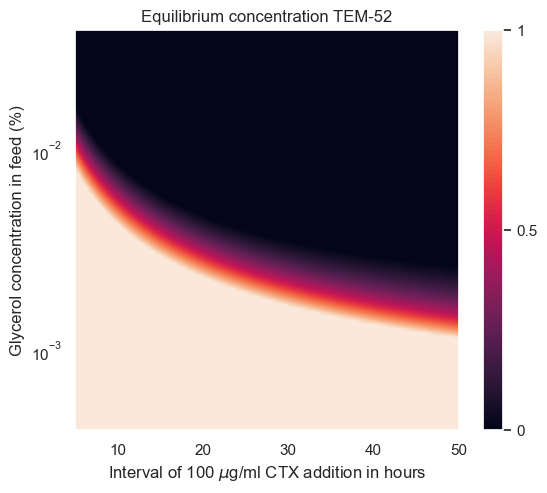

In [13]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(I, G, EQ_intermittend, levels)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration TEM-52')
ax.set_xlabel(r'Interval of 100 $\mu$g/ml CTX addition in hours')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xlim(5, 50)
ax.set_ylim(0.0004, 0.04)
plt.show()

In [14]:
#convert interval to doses per day (24/interval)
I_new = 24/I

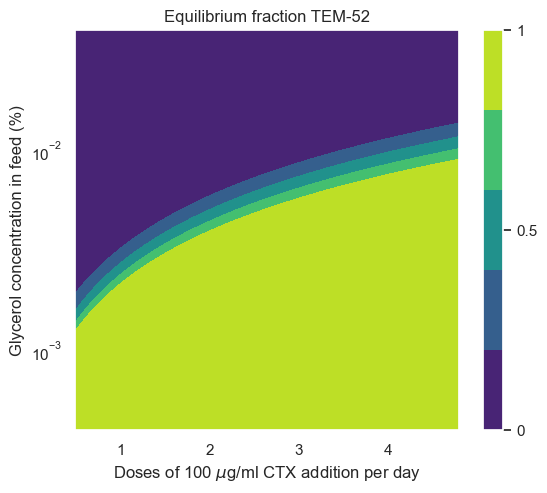

In [15]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(I_new, G, EQ_intermittend, levels=4,cmap=cm.viridis)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium fraction TEM-52')
ax.set_xlabel(r'Doses of 100 $\mu$g/ml CTX addition per day')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xlim(24/50, 24/5)
ax.set_ylim(0.0004, 0.04)

plt.show()

## Convert to approximate population size

In [16]:
popsize_coex = [ffc.N_tot(g_feed, d_graph, ffc.g_min(d_graph, ffc.growth(sol_a_eq, **p_R), **p_R), mu_coex = ffc.growth(sol_a_eq, **p_R), **p_R) for g_feed in glycerol_array]
I_P, P = np.meshgrid(interval_array, popsize_coex)

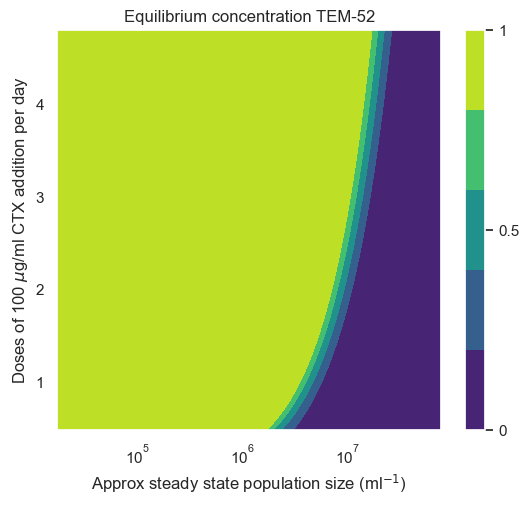

In [17]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(P, I_new, EQ_intermittend, levels=4,cmap=cm.viridis)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration TEM-52')
ax.set_ylabel(r'Doses of 100 $\mu$g/ml CTX addition per day')
ax.set_xlabel('Approx steady state population size (ml$^{-1}$)')
ax.set_xscale('log')
ax.set_ylim(24/50, 24/5)
ax.set_yticks([1,2,3,4])

#plt.savefig("chemostat_figure_doses.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Extra degradation of the antibiotics (supplementary figure)

In [18]:
eq_ratio_partial_extra_degration = partial(ffc.equilibrium_ratio_serial, amount=100, d=0.1, d_e_a=5, p_R=p_R, p_S=p_S, sensitivity=0.001, max_iterations=50)
equilibrium_ratio_array_intermittend_extra_degradation = np.frompyfunc(eq_ratio_partial_extra_degration, 2, 1)

In [20]:
interval_array = np.linspace(5,50,100, endpoint=True)
glycerol_array = np.geomspace(0.0004,0.04,100)

I, G = np.meshgrid(interval_array, glycerol_array)
tic = time.perf_counter()
EQ_intermittend_extra_degradation = equilibrium_ratio_array_intermittend_extra_degradation(G, I)
EQ_intermittend_extra_degradation = EQ_intermittend_extra_degradation.astype(float)
toc = time.perf_counter()
print(f"The simulations take {toc - tic:0.4f} seconds")

The simulations take 1173.0043 seconds


In [21]:
#export data
np.save('data/eqratios_intermittend_extra_degradation.npy', EQ_intermittend, allow_pickle=True)

In [22]:
#load data
#EQ_intermittend = np.load('data/eqratios_intermittend_extra_degradation.npy', allow_pickle=True)

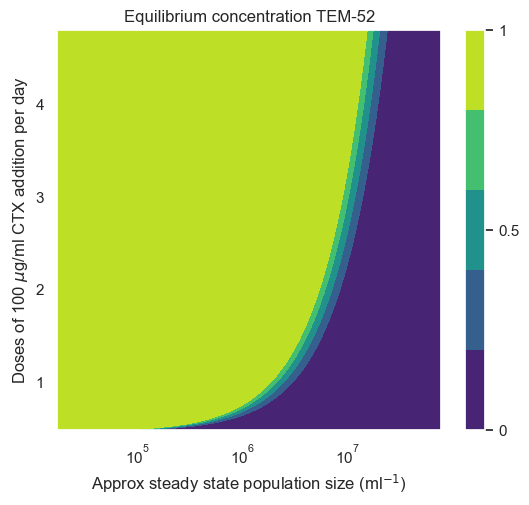

In [26]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(P, I_new, EQ_intermittend_extra_degradation, levels=4,cmap=cm.viridis)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration TEM-52')
ax.set_ylabel(r'Doses of 100 $\mu$g/ml CTX addition per day')
ax.set_xlabel('Approx steady state population size (ml$^{-1}$)')
ax.set_xscale('log')
ax.set_ylim(24/50, 24/5)
ax.set_yticks([1,2,3,4])

plt.show()

# Go from glycerol concentration to approximate density

We calculate the density a strain or combination of strains would reach as function of the glycerol concentrations in the feed, when no antibiotics would be added (but a strain or coexistence would be imposed -> in the case of coexistence this is of course an approximation because there would be no coexistence without antibiotics addition). 

This differs for resident strains, so we calculate it for three cases:
1. susceptible resident
2. resistent resident
3. coexistence

In [24]:
#in case of susceptible resident
popsize_S = [ffc.N_tot(g_feed, d_graph, ffc.g_min(d_graph, ffc.growth(0, **p_S), **p_S), mu_coex = ffc.growth(0, **p_S), **p_S) for g_feed in glycerol_array]
#in case of resistent resident
popsize_R = [ffc.N_tot(g_feed, d_graph, ffc.g_min(d_graph, ffc.growth(0, **p_R), **p_R), mu_coex = ffc.growth(0, **p_R), **p_R) for g_feed in glycerol_array]
#in case of equilibrium
popsize_coex = [ffc.N_tot(g_feed, d_graph, ffc.g_min(d_graph, ffc.growth(sol_a_eq, **p_R), **p_R), mu_coex = ffc.growth(sol_a_eq, **p_R), **p_R) for g_feed in glycerol_array]

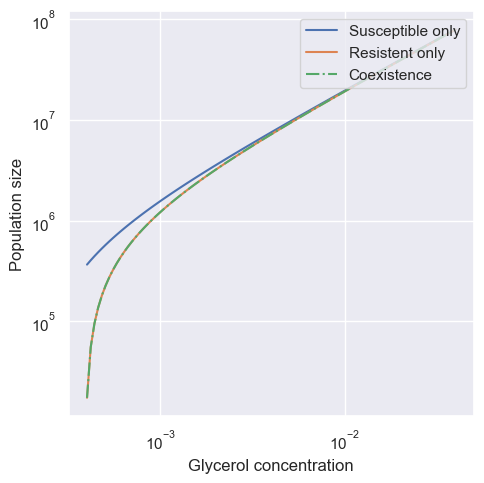

In [25]:
fig, axes = plt.subplots(1,1, figsize=(5,5))

axes.plot(glycerol_array, popsize_S)
axes.plot(glycerol_array, popsize_R)
axes.plot(glycerol_array, popsize_coex, '-.')

axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Glycerol concentration')
axes.set_ylabel('Population size')
axes.legend(tuple(['Susceptible only', 'Resistent only', 'Coexistence']), loc="upper right")
plt.tight_layout()

Resistent and coex population size are approximately the same. The susceptible population size mostly differs at low glycerol concentrations, and that is when we most find the resistant strain, so we decided to use the coexistence population size to calculate the approximate steady state population size.